# Canopy Height Model (CHM) Generation - CyVerse/Local Version

Generate Canopy Height Models from USGS 3D Elevation Program (3DEP) lidar data.

**Modified from:** [OpenTopography OT_3DEP_Workflows](https://github.com/OpenTopography/OT_3DEP_Workflows)

## Key Features

- **Adaptive Resolution:** 0.5m for <12 points/m², 0.333m for >=12 points/m²
- **Direct CHM Calculation:** Simple DSM - DTM subtraction (no smoothing/IDW)
- **CyVerse Compatible:** Writes to local storage first, then copies to Data Store
- **Batch Ready:** Modular design for multi-site processing

## Requirements

```bash
conda activate 3dep
```

## 1. Environment Setup

In [30]:
# Environment validation
import sys

REQUIRED_PACKAGES = ['pdal', 'geopandas', 'rioxarray', 'pyproj', 'shapely', 'numpy']
missing = []

for pkg in REQUIRED_PACKAGES:
    try:
        __import__(pkg)
    except ImportError:
        missing.append(pkg)

if missing:
    raise ImportError(
        f"Missing packages: {missing}\n"
        f"Please activate the 3dep conda environment:\n"
        f"  conda activate 3dep"
    )

print("Environment validated successfully!")

Environment validated successfully!


In [31]:
# Import libraries
import json
import os
import shutil
from pathlib import Path
from datetime import datetime

import geopandas as gpd
import numpy as np
import pdal
import pyproj
import requests
import rioxarray as rio
import xarray as xr
from rasterio.enums import Resampling
from shapely.geometry import shape, box
from shapely.ops import transform
import matplotlib.pyplot as plt

print(f"Libraries loaded at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries loaded at 2025-12-18 23:09:41


## 2. Configuration

**Important:** We write outputs to local storage (`/home/jovyan/outputs/`) first for better I/O performance, then copy to the CyVerse Data Store in a separate step.

In [32]:
# Output configuration
# LOCAL storage for fast I/O during processing
LOCAL_OUTPUT_BASE = Path("/home/jovyan/outputs/3dep")
LOCAL_OUTPUT_CHM = LOCAL_OUTPUT_BASE / "chm"
LOCAL_OUTPUT_DTM = LOCAL_OUTPUT_BASE / "dtm"
LOCAL_OUTPUT_DSM = LOCAL_OUTPUT_BASE / "dsm"

# CyVerse Data Store for final storage (slow I/O - CSI mount)
DATASTORE_OUTPUT_BASE = Path("/data-store/iplant/home/tswetnam/fractal-notebooks/docs/notebooks/3dep/outputs")

# Create local output directories
for d in [LOCAL_OUTPUT_CHM, LOCAL_OUTPUT_DTM, LOCAL_OUTPUT_DSM]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Local output directories created under: {LOCAL_OUTPUT_BASE}")
print(f"Final storage location: {DATASTORE_OUTPUT_BASE}")

Local output directories created under: /home/jovyan/outputs/3dep
Final storage location: /data-store/iplant/home/tswetnam/fractal-notebooks/docs/notebooks/3dep/outputs


In [33]:
# Resolution configuration
# Resolution is determined by point density:
#   - >= 12 points/m² -> 0.333m resolution
#   - <  12 points/m² -> 0.5m resolution

DENSITY_THRESHOLD = 12  # points per square meter
RESOLUTION_HIGH = 0.333  # for high density (>= threshold)
RESOLUTION_STANDARD = 0.5  # for standard density (< threshold)

# Output CRS
OUTPUT_CRS = 3857  # Web Mercator

def get_resolution(point_density_per_m2):
    """Select output resolution based on point density.
    
    Args:
        point_density_per_m2: Estimated point density in points/m²
        
    Returns:
        Resolution in meters (0.333 or 0.5)
    """
    if point_density_per_m2 >= DENSITY_THRESHOLD:
        return RESOLUTION_HIGH
    return RESOLUTION_STANDARD

print(f"Resolution rules:")
print(f"  >= {DENSITY_THRESHOLD} pts/m² -> {RESOLUTION_HIGH}m")
print(f"  <  {DENSITY_THRESHOLD} pts/m² -> {RESOLUTION_STANDARD}m")

Resolution rules:
  >= 12 pts/m² -> 0.333m
  <  12 pts/m² -> 0.5m


## 3. Utility Functions

In [34]:
def gcs_to_proj(poly):
    """Reproject from EPSG:4326 to EPSG:3857."""
    wgs84 = pyproj.CRS("EPSG:4326")
    web_mercator = pyproj.CRS("EPSG:3857")
    project = pyproj.Transformer.from_crs(wgs84, web_mercator, always_xy=True).transform
    return transform(project, poly)


def proj_to_gcs(poly):
    """Reproject from EPSG:3857 to EPSG:4326."""
    wgs84 = pyproj.CRS("EPSG:4326")
    web_mercator = pyproj.CRS("EPSG:3857")
    project = pyproj.Transformer.from_crs(web_mercator, wgs84, always_xy=True).transform
    return transform(project, poly)

In [35]:
def make_dem_pipeline(
    extent_epsg3857,
    usgs_3dep_dataset_names,
    pc_resolution,
    dem_resolution,
    dem_type,  # 'dsm' or 'dtm'
    dem_out_path,
    filter_noise=True,
    out_crs=3857
):
    """Build PDAL pipeline for DEM generation.
    
    Uses 'max' for DSM and 'min' for DTM - NO IDW smoothing.
    
    Args:
        extent_epsg3857: AOI polygon in EPSG:3857 (WKT string)
        usgs_3dep_dataset_names: List of 3DEP dataset names
        pc_resolution: Point cloud resolution parameter
        dem_resolution: Output DEM resolution in meters
        dem_type: 'dsm' (all points) or 'dtm' (ground only)
        dem_out_path: Output file path
        filter_noise: Remove noise classes
        out_crs: Output CRS EPSG code
        
    Returns:
        PDAL pipeline dictionary
    """
    # Build readers for each dataset
    readers = []
    for name in usgs_3dep_dataset_names:
        url = f"https://s3-us-west-2.amazonaws.com/usgs-lidar-public/{name}/ept.json"
        reader = {
            "type": "readers.ept",
            "filename": url,
            "polygon": str(extent_epsg3857),
            "requests": 3,
            "resolution": pc_resolution
        }
        readers.append(reader)
    
    pipeline = {"pipeline": readers}
    
    if filter_noise:
        # Remove Class 7 (low noise) and Class 18 (high noise)
        pipeline['pipeline'].append({
            "type": "filters.range",
            "limits": "Classification![7:7]"
        })
        pipeline['pipeline'].append({
            "type": "filters.range",
            "limits": "Classification![18:18]"
        })
    
    # Reproject to output CRS
    pipeline['pipeline'].append({
        "type": "filters.reprojection",
        "out_srs": f"EPSG:{out_crs}"
    })
    
    if dem_type == 'dtm':
        # Filter to ground points only (Class 2)
        pipeline['pipeline'].append({
            "type": "filters.range",
            "limits": "Classification[2:2]"
        })
        # Use MIN for DTM (lowest point = ground)
        grid_method = "min"
    else:
        # Use MAX for DSM (highest point = canopy/surface)
        grid_method = "max"
    
    # Add GDAL writer with explicit CRS
    pipeline['pipeline'].append({
        "type": "writers.gdal",
        "filename": str(dem_out_path),
        "gdaldriver": "GTiff",
        "nodata": -9999,
        "output_type": grid_method,
        "resolution": float(dem_resolution),
        "gdalopts": f"COMPRESS=LZW,TILED=YES,BLOCKXSIZE=256,BLOCKYSIZE=256",
        "override_srs": f"EPSG:{out_crs}"  # Explicitly set CRS in output
    })
    
    return pipeline

## 4. Load 3DEP Dataset Boundaries

In [36]:
print("Loading 3DEP dataset boundaries...")

# Fetch 3DEP boundaries from Hobu Inc repository
url = 'https://raw.githubusercontent.com/hobuinc/usgs-lidar/master/boundaries/resources.geojson'
r = requests.get(url)

# Save locally for reference (to local storage, not Data Store)
boundaries_file = LOCAL_OUTPUT_BASE / 'resources.geojson'
with open(boundaries_file, 'w') as f:
    f.write(r.content.decode("utf-8"))

# Load as GeoDataFrame
df_3dep = gpd.read_file(boundaries_file)

# Project geometries to EPSG:3857
df_3dep['geometry_3857'] = df_3dep['geometry'].apply(gcs_to_proj)

print(f"Loaded {len(df_3dep)} 3DEP datasets")
print(f"Total points available: {df_3dep['count'].sum():,.0f}")

Loading 3DEP dataset boundaries...
Loaded 2220 3DEP datasets
Total points available: 73,462,915,716,133


## 5. Define Area of Interest (AOI)

Current AOI: **Monument Canyon Research Natural Area, NM**

In [37]:
# Define AOI using GeoJSON
# Monument Canyon Research Natural Area, NM

AOI_GEOJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [-106.64270398641813, 35.81386115600991],
            [-106.64270398641813, 35.79252004986472],
            [-106.6172480729282, 35.79252004986472],
            [-106.6172480729282, 35.81386115600991],
            [-106.64270398641813, 35.81386115600991]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

SITE_NAME = "monument_canyon_rna"

# Parse GeoJSON and create AOI
feature = AOI_GEOJSON['features'][0]
AOI_GCS = shape(feature['geometry'])
AOI_EPSG3857 = gcs_to_proj(AOI_GCS)

# Calculate bounding box for reference
AOI_BBOX = list(AOI_GCS.bounds)  # [west, south, east, north]

print(f"Site: {SITE_NAME}")
print(f"Bounding box (WGS84): {AOI_BBOX}")
print(f"Area: {AOI_EPSG3857.area / 1e6:.4f} km²")

Site: monument_canyon_rna
Bounding box (WGS84): [-106.64270398641813, 35.79252004986472, -106.6172480729282, 35.81386115600991]
Area: 8.3006 km²


## 6. Find Intersecting 3DEP Datasets

In [38]:
# Find 3DEP datasets that intersect with our AOI
intersecting = []

for idx, row in df_3dep.iterrows():
    if row['geometry_3857'].intersects(AOI_EPSG3857):
        intersecting.append({
            'name': row['name'],
            'url': row['url'],
            'count': row['count'],
            'geometry_gcs': row['geometry'],
            'geometry_3857': row['geometry_3857']
        })

if not intersecting:
    raise ValueError("No 3DEP datasets found for this AOI. Check coordinates.")

print(f"Found {len(intersecting)} intersecting 3DEP dataset(s):")
for ds in intersecting:
    print(f"  - {ds['name']}: {ds['count']:,} points")

# Extract dataset names for PDAL
dataset_names = [ds['name'] for ds in intersecting]

Found 2 intersecting 3DEP dataset(s):
  - NM_NorthCentral_B1_2016: 48,720,670,453 points
  - NM_SouthCentral_B9_2018: 20,850,776,931 points


## 7. Estimate Point Density and Select Resolution

In [39]:
# Estimate point density for our AOI
total_points_estimate = 0

for ds in intersecting:
    # Ratio of AOI area to dataset area
    ratio = AOI_EPSG3857.area / ds['geometry_3857'].area
    points_estimate = ratio * ds['count']
    total_points_estimate += points_estimate

# Calculate density
aoi_area_m2 = AOI_EPSG3857.area
estimated_density = total_points_estimate / aoi_area_m2

# Select resolution based on density
selected_resolution = get_resolution(estimated_density)

print(f"AOI Area: {aoi_area_m2 / 1e6:.4f} km² ({aoi_area_m2:,.0f} m²)")
print(f"Estimated points: {total_points_estimate:,.0f}")
print(f"Estimated density: {estimated_density:.1f} points/m²")
print(f"")
print(f"Selected resolution: {selected_resolution}m")
print(f"  (Threshold: {DENSITY_THRESHOLD} pts/m² -> "
      f"{'HIGH' if estimated_density >= DENSITY_THRESHOLD else 'STANDARD'} resolution)")

AOI Area: 8.3006 km² (8,300,619 m²)
Estimated points: 53,943,549
Estimated density: 6.5 points/m²

Selected resolution: 0.5m
  (Threshold: 12 pts/m² -> STANDARD resolution)


## 8. Generate Digital Surface Model (DSM)

Writing to **local storage** for fast I/O.

In [40]:
# DSM output path (LOCAL storage)
dsm_path = LOCAL_OUTPUT_DSM / f"{SITE_NAME}_dsm.tif"

print(f"Generating DSM at {selected_resolution}m resolution...")
print(f"Output (local): {dsm_path}")
print(f"Method: MAX (highest point per cell - NO IDW)")

# Build pipeline
dsm_pipeline_dict = make_dem_pipeline(
    extent_epsg3857=AOI_EPSG3857.wkt,
    usgs_3dep_dataset_names=dataset_names,
    pc_resolution=1.0,  # Full resolution point cloud
    dem_resolution=selected_resolution,
    dem_type='dsm',
    dem_out_path=dsm_path,
    filter_noise=True,
    out_crs=OUTPUT_CRS
)

# Execute
dsm_pipeline = pdal.Pipeline(json.dumps(dsm_pipeline_dict))

start_time = datetime.now()
dsm_pipeline.execute_streaming(chunk_size=1000000)
elapsed = (datetime.now() - start_time).total_seconds()

print(f"DSM complete in {elapsed:.1f} seconds")
print(f"File size: {dsm_path.stat().st_size / 1e6:.1f} MB")

Generating DSM at 0.5m resolution...
Output (local): /home/jovyan/outputs/3dep/dsm/monument_canyon_rna_dsm.tif
Method: MAX (highest point per cell - NO IDW)
DSM complete in 117.8 seconds
File size: 97.5 MB


## 9. Generate Digital Terrain Model (DTM)

Writing to **local storage** for fast I/O.

In [41]:
# DTM output path (LOCAL storage)
dtm_path = LOCAL_OUTPUT_DTM / f"{SITE_NAME}_dtm.tif"

print(f"Generating DTM at {selected_resolution}m resolution...")
print(f"Output (local): {dtm_path}")
print(f"Method: MIN (lowest ground point per cell - NO IDW)")

# Build pipeline
dtm_pipeline_dict = make_dem_pipeline(
    extent_epsg3857=AOI_EPSG3857.wkt,
    usgs_3dep_dataset_names=dataset_names,
    pc_resolution=1.0,  # Full resolution point cloud
    dem_resolution=selected_resolution,
    dem_type='dtm',
    dem_out_path=dtm_path,
    filter_noise=True,
    out_crs=OUTPUT_CRS
)

# Execute
dtm_pipeline = pdal.Pipeline(json.dumps(dtm_pipeline_dict))

start_time = datetime.now()
dtm_pipeline.execute_streaming(chunk_size=1000000)
elapsed = (datetime.now() - start_time).total_seconds()

print(f"DTM complete in {elapsed:.1f} seconds")
print(f"File size: {dtm_path.stat().st_size / 1e6:.1f} MB")

Generating DTM at 0.5m resolution...
Output (local): /home/jovyan/outputs/3dep/dtm/monument_canyon_rna_dtm.tif
Method: MIN (lowest ground point per cell - NO IDW)
DTM complete in 120.9 seconds
File size: 82.5 MB


## 10. Calculate Canopy Height Model (CHM)

**CHM = DSM - DTM**

Simple direct subtraction with no smoothing or interpolation.

In [42]:
# Load DSM and DTM from local storage
print("Loading DSM and DTM from local storage...")

dsm = rio.open_rasterio(dsm_path, masked=True)
dtm = rio.open_rasterio(dtm_path, masked=True)

print(f"DSM shape: {dsm.shape}, CRS: {dsm.rio.crs}")
print(f"DTM shape: {dtm.shape}, CRS: {dtm.rio.crs}")

Loading DSM and DTM from local storage...
DSM shape: (1, 5859, 5668), CRS: EPSG:3857
DTM shape: (1, 5859, 5669), CRS: EPSG:3857


In [43]:
# Verify CRS is set, fix if needed
if dsm.rio.crs is None:
    print("Warning: DSM missing CRS, setting to EPSG:3857")
    dsm = dsm.rio.write_crs(f"EPSG:{OUTPUT_CRS}")

if dtm.rio.crs is None:
    print("Warning: DTM missing CRS, setting to EPSG:3857")
    dtm = dtm.rio.write_crs(f"EPSG:{OUTPUT_CRS}")

# Align rasters if shapes don't match
if dsm.shape != dtm.shape:
    print(f"Raster shapes differ: DSM={dsm.shape}, DTM={dtm.shape}")
    print("Aligning rasters...")
    
    # Use the smaller raster as reference
    if dsm.shape[1] * dsm.shape[2] > dtm.shape[1] * dtm.shape[2]:
        dsm = dsm.rio.reproject_match(dtm)
        print(f"DSM reprojected to match DTM: {dsm.shape}")
    else:
        dtm = dtm.rio.reproject_match(dsm)
        print(f"DTM reprojected to match DSM: {dtm.shape}")

print(f"\nFinal shapes: DSM={dsm.shape}, DTM={dtm.shape}")

Raster shapes differ: DSM=(1, 5859, 5668), DTM=(1, 5859, 5669)
Aligning rasters...
DTM reprojected to match DSM: (1, 5859, 5668)

Final shapes: DSM=(1, 5859, 5668), DTM=(1, 5859, 5668)


In [44]:
# Calculate CHM: Direct subtraction only
print("Calculating CHM = DSM - DTM (direct subtraction, no smoothing)...")

# Ensure coordinates match exactly
dsm = dsm.assign_coords({"x": dtm.x, "y": dtm.y})

chm = dsm - dtm

# Set NoData value
nodata_val = -9999
chm = chm.rio.write_nodata(nodata_val)
chm = chm.rio.write_crs(f"EPSG:{OUTPUT_CRS}")

# Save CHM to local storage
chm_path = LOCAL_OUTPUT_CHM / f"{SITE_NAME}_chm.tif"
chm.rio.to_raster(chm_path, driver="GTiff", compress="LZW", tiled=True)

print(f"CHM saved to: {chm_path}")
print(f"File size: {chm_path.stat().st_size / 1e6:.1f} MB")

Calculating CHM = DSM - DTM (direct subtraction, no smoothing)...
CHM saved to: /home/jovyan/outputs/3dep/chm/monument_canyon_rna_chm.tif
File size: 86.8 MB


## 11. Calculate Statistics and Generate Metadata

In [45]:
# Calculate CHM statistics
chm_data = chm.values.flatten()
chm_valid = chm_data[~np.isnan(chm_data)]
chm_valid = chm_valid[chm_valid != nodata_val]

# Filter to reasonable height values (0-150m)
chm_heights = chm_valid[(chm_valid >= 0) & (chm_valid <= 150)]

stats = {
    'site_name': SITE_NAME,
    'bbox': AOI_BBOX,
    'area_km2': aoi_area_m2 / 1e6,
    'resolution_m': selected_resolution,
    'point_density_est': estimated_density,
    'datasets_used': dataset_names,
    'crs': f'EPSG:{OUTPUT_CRS}',
    'processing': {
        'dsm_method': 'max',
        'dtm_method': 'min',
        'smoothing': 'none',
        'interpolation': 'none'
    },
    'chm_statistics': {
        'min_height_m': float(np.min(chm_heights)) if len(chm_heights) > 0 else None,
        'max_height_m': float(np.max(chm_heights)) if len(chm_heights) > 0 else None,
        'mean_height_m': float(np.mean(chm_heights)) if len(chm_heights) > 0 else None,
        'median_height_m': float(np.median(chm_heights)) if len(chm_heights) > 0 else None,
        'std_height_m': float(np.std(chm_heights)) if len(chm_heights) > 0 else None,
        'valid_pixels': int(len(chm_heights)),
        'total_pixels': int(len(chm_data))
    },
    'generated_at': datetime.now().isoformat(),
    'source': 'USGS 3DEP via OpenTopography'
}

# Print summary
print("CHM Statistics:")
if stats['chm_statistics']['min_height_m'] is not None:
    print(f"  Min height:    {stats['chm_statistics']['min_height_m']:.2f} m")
    print(f"  Max height:    {stats['chm_statistics']['max_height_m']:.2f} m")
    print(f"  Mean height:   {stats['chm_statistics']['mean_height_m']:.2f} m")
    print(f"  Median height: {stats['chm_statistics']['median_height_m']:.2f} m")
    print(f"  Std deviation: {stats['chm_statistics']['std_height_m']:.2f} m")
    print(f"  Valid pixels:  {stats['chm_statistics']['valid_pixels']:,}")
else:
    print("  No valid height data found!")

CHM Statistics:
  Min height:    0.00 m
  Max height:    53.81 m
  Mean height:   6.37 m
  Median height: 1.95 m
  Std deviation: 7.82 m
  Valid pixels:  27,497,034


In [46]:
# Save metadata to local storage
metadata_path = LOCAL_OUTPUT_CHM / f"{SITE_NAME}_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(stats, f, indent=2)

print(f"Metadata saved to: {metadata_path}")

Metadata saved to: /home/jovyan/outputs/3dep/chm/monument_canyon_rna_metadata.json


## 12. Visualize CHM

In [48]:
# Downsample for visualization if needed
def downsample_for_plot(raster, max_dim=1000):
    """Downsample raster for efficient plotting."""
    if max(raster.shape) > max_dim:
        scale = max_dim / max(raster.shape[1], raster.shape[2])
        new_width = int(raster.rio.width * scale)
        new_height = int(raster.rio.height * scale)
        return raster.rio.reproject(
            raster.rio.crs,
            shape=(new_height, new_width),
            resampling=Resampling.bilinear
        )
    return raster

chm_plot = downsample_for_plot(chm.squeeze())

IndexError: tuple index out of range

NameError: name 'chm_plot' is not defined

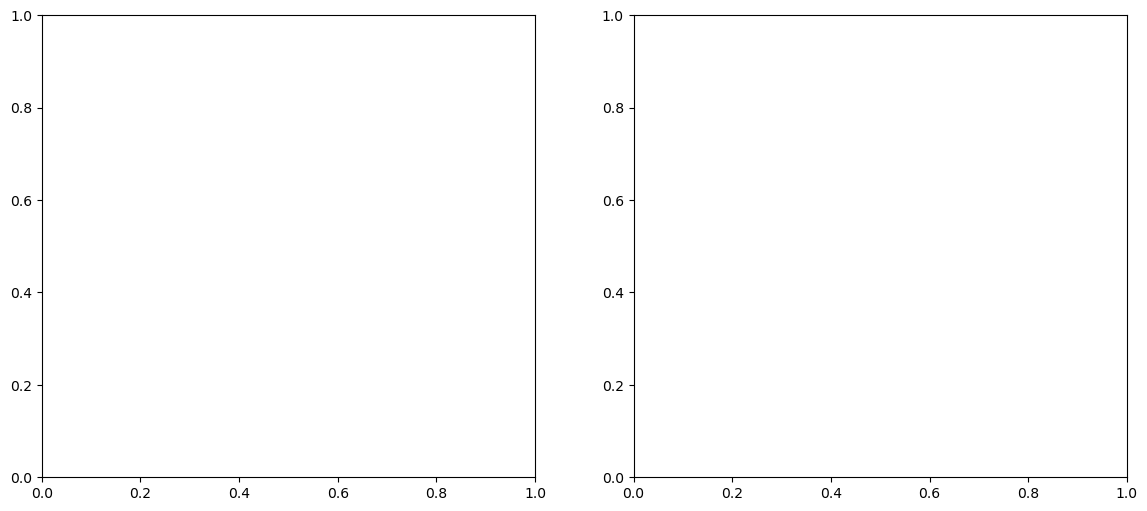

In [54]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# CHM map
ax1 = axes[0]
im = chm_plot.plot(ax=ax1, cmap='Greens', robust=True, add_colorbar=False)
ax1.set_title(f"Canopy Height Model: {SITE_NAME}")
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax1.ticklabel_format(style='plain')
ax1.set_aspect('equal')
plt.colorbar(im, ax=ax1, label='Height (m)')

# Height histogram
ax2 = axes[1]
if len(chm_heights) > 0:
    ax2.hist(chm_heights, bins=50, color='green', alpha=0.7, edgecolor='darkgreen')
    ax2.axvline(stats['chm_statistics']['mean_height_m'], color='red', 
                linestyle='--', label=f"Mean: {stats['chm_statistics']['mean_height_m']:.1f}m")
    ax2.axvline(stats['chm_statistics']['median_height_m'], color='orange', 
                linestyle='--', label=f"Median: {stats['chm_statistics']['median_height_m']:.1f}m")
    ax2.legend()
ax2.set_title("Height Distribution")
ax2.set_xlabel("Canopy Height (m)")
ax2.set_ylabel("Pixel Count")

plt.tight_layout()

# Save figure to local storage
preview_path = LOCAL_OUTPUT_CHM / f"{SITE_NAME}_preview.png"
plt.savefig(preview_path, dpi=150, bbox_inches='tight')
print(f"Preview saved to: {preview_path}")

plt.show()

## 13. Cleanup Memory

In [55]:
# Close raster handles and free memory
dsm.close()
dtm.close()
chm.close()

del dsm, dtm, chm, chm_plot

print("Memory cleaned up.")

NameError: name 'dsm' is not defined

## 14. Copy Outputs to CyVerse Data Store

Now that processing is complete, copy the outputs from local storage to the CyVerse Data Store for persistent storage.

In [56]:
# Create Data Store output directories
DATASTORE_CHM = DATASTORE_OUTPUT_BASE / "chm"
DATASTORE_DTM = DATASTORE_OUTPUT_BASE / "dtm"
DATASTORE_DSM = DATASTORE_OUTPUT_BASE / "dsm"

for d in [DATASTORE_CHM, DATASTORE_DTM, DATASTORE_DSM]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Data Store directories created under: {DATASTORE_OUTPUT_BASE}")

Data Store directories created under: /data-store/iplant/home/tswetnam/fractal-notebooks/docs/notebooks/3dep/outputs


In [57]:
# Copy files to Data Store
print("Copying outputs to CyVerse Data Store...")
print("(This may take a while due to CSI mount I/O)")
print()

files_to_copy = [
    (dsm_path, DATASTORE_DSM / dsm_path.name),
    (dtm_path, DATASTORE_DTM / dtm_path.name),
    (chm_path, DATASTORE_CHM / chm_path.name),
    (metadata_path, DATASTORE_CHM / metadata_path.name),
    (preview_path, DATASTORE_CHM / preview_path.name),
]

for src, dst in files_to_copy:
    if src.exists():
        start = datetime.now()
        print(f"  Copying {src.name}...", end=" ", flush=True)
        shutil.copy2(src, dst)
        elapsed = (datetime.now() - start).total_seconds()
        print(f"done ({elapsed:.1f}s)")
    else:
        print(f"  Skipping {src.name} (not found)")

print()
print("Copy complete!")

Copying outputs to CyVerse Data Store...
(This may take a while due to CSI mount I/O)



NameError: name 'preview_path' is not defined

In [ ]:
print("\n" + "="*60)
print("CHM GENERATION COMPLETE!")
print("="*60)
print(f"\nLocal outputs: {LOCAL_OUTPUT_BASE}")
print(f"Data Store outputs: {DATASTORE_OUTPUT_BASE}")
print(f"\nFiles generated:")
print(f"  - CHM: {SITE_NAME}_chm.tif")
print(f"  - DSM: {SITE_NAME}_dsm.tif")
print(f"  - DTM: {SITE_NAME}_dtm.tif")
print(f"  - Metadata: {SITE_NAME}_metadata.json")
print(f"  - Preview: {SITE_NAME}_preview.png")

---

## References

- Original notebook: [OpenTopography OT_3DEP_Workflows](https://github.com/OpenTopography/OT_3DEP_Workflows)
- 3DEP Program: https://www.usgs.gov/3d-elevation-program
- PDAL Documentation: https://pdal.io/